In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  # carma_variance

Text(0,0.5,'magnitude')

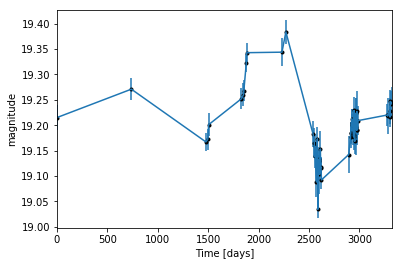

In [2]:
data = np.genfromtxt('LC_I_18822.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')

In [3]:
model = cm.CarmaModel(t, y, yerr, p=4, q=1)

In [4]:
%%capture capt
sample = model.run_mcmc(20000)

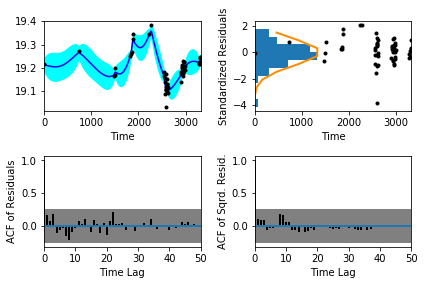

In [5]:
sample.assess_fit()

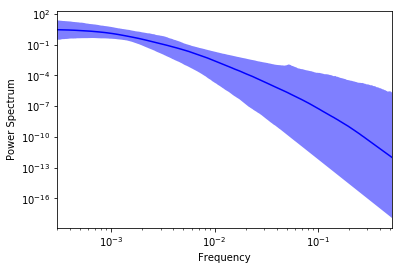

In [6]:
psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)


In [7]:
dt = t[1:] - t[:-1]
noise_level = 2.0 * np.mean(dt) * np.mean(yerr ** 2)

Text(0.000376389,0.0525109,'Nivel de ruido')

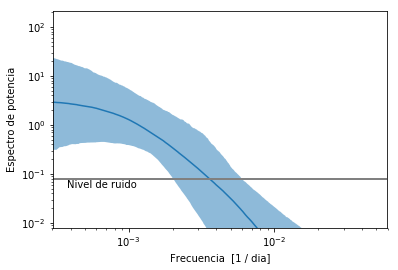

In [8]:
plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.ylim(noise_level / 10.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Espectro de potencia')
plt.xlabel('Frecuencia  [1 / dia]')
plt.annotate("Nivel de ruido", (1.25* plt.xlim()[0], noise_level / 1.5))

Text(0.5,1,'Forecasting, Expected Value')

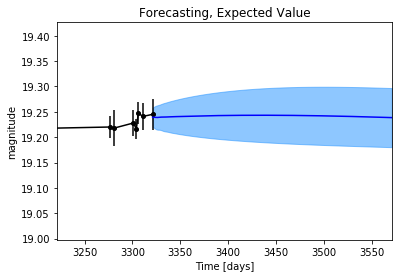

In [9]:
tpredict = t.max() + np.linspace(0.0, 250.0, 250)
ypredict, yp_var = sample.predict(tpredict)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tpredict, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tpredict, ypredict, 'b-')
plt.xlim(tpredict.min() - 100, tpredict.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.title('Forecasting, Expected Value')

Text(0.5,1,'Forecasting, Simulated Paths')

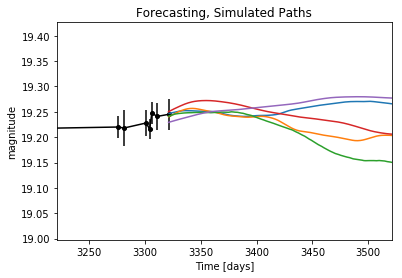

In [10]:
tpredict = t.max() + np.linspace(0.0, 200.0, 250)
npaths = 5
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
for i in range(npaths):
    ysim = sample.simulate(tpredict, bestfit='random')  # use a random draw of the CARMA parameters from its posterior
    plt.plot(tpredict, ysim)
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.xlim(tpredict.min()-100, tpredict.max())
plt.title('Forecasting, Simulated Paths')

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


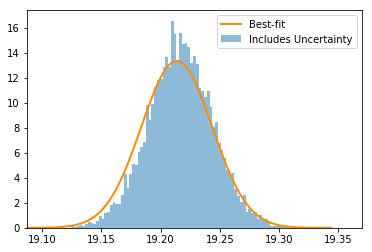

In [11]:
tpredict = 10.0
nsim = 10000
ysim = np.zeros(nsim)
for i in range(nsim):
    ysim[i] = sample.simulate(tpredict, bestfit='random')
yhat, yhvar = sample.predict(tpredict)
plt.hist(ysim, bins=100, alpha=0.5, histtype='stepfilled', normed=True, label='Includes Uncertainty')
ymin, ymax = plt.xlim()
ygrid = np.linspace(ymin, ymax, 200)
predictive_pdf = 1.0 / np.sqrt(2.0 * np.pi * yhvar) * np.exp(-0.5 * (ygrid - yhat) ** 2 / yhvar)
plt.plot(ygrid, predictive_pdf, color='DarkOrange', lw=2, label='Best-fit')
plt.xlim(ymin, ymax + 0.1 * (ymax - ymin))
plt.legend(loc='upper right')

Text(0.5,1,'Interpolacion, camino simulado')

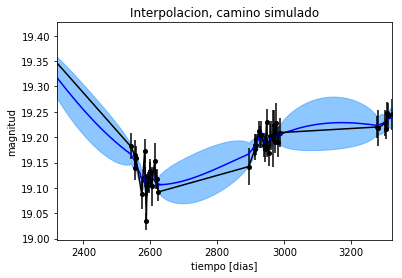

In [12]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
ypredict, yp_var = sample.predict(tinterp)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tinterp, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tinterp, ypredict, 'b-')
plt.xlabel('tiempo [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Text(0.5,1,'Interpolacion, camino simulado')

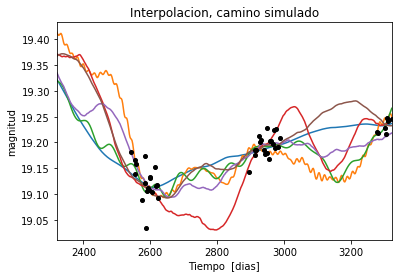

In [13]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
npaths = 6
for i in range(npaths):
    ysim = sample.simulate(tinterp, bestfit='random')
    plt.plot(tinterp, ysim)
plt.plot(t, y, 'ko', ms=4)
plt.xlabel('Tiempo  [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

In [14]:
sample.parameters

['quad_coefs',
 'logpost',
 'ar_coefs',
 'mu',
 'psd_centroid',
 'loglik',
 'psd_width',
 'var',
 'measerr_scale',
 'sigma',
 'ma_coefs',
 'ar_roots']

In [15]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [16]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 743.278947974
Median: 0.00846470805659
Standard deviation: 0.241787318916
68% credibility interval: [ 0.          0.34144385]
95% credibility interval: [ 0.          0.89790951]
99% credibility interval: [ 0.          1.01462641]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 743.278947974
Median: 0.00846470805659
Standard deviation: 0.241787318916
68% credibility interval: [ 0.          0.34144385]
95% credibility interval: [ 0.          0.89790951]
99% credibility interval: [ 0.          1.01462641]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 1316.15854371
Median: 0.0
Standard deviation: 0.000624303038405
68% 

Plotting parameter summary


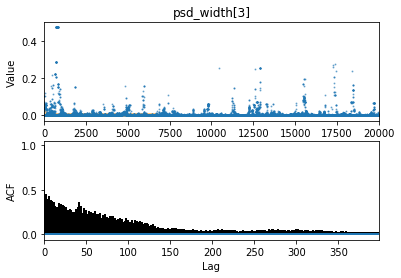

In [17]:
sample.plot_parameter('psd_width', 3, doShow=True)

In [18]:
centroid_samples = sample.get_samples('logpost')
centroid_samples.shape

(20000, 1)

In [19]:
sample.posterior_summaries('logpost')

Calculating effective number of samples
Posterior summary for parameter logpost  element 0
----------------------------------------------
Effective number of independent samples: 653.13775539
Median: 134.44897557
Standard deviation: 1.71147905281
68% credibility interval: [ 132.56533757  135.65278683]
95% credibility interval: [ 129.97070095  136.56399831]
99% credibility interval: [ 127.95623813  137.64426024]


In [20]:
centroid_samples = sample.get_samples('ar_coefs')
centroid_samples.shape

(20000, 5)

In [21]:
sample.posterior_summaries('ar_coefs')

Calculating effective number of samples
Posterior summary for parameter ar_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ar_coefs  element 1
----------------------------------------------
Effective number of independent samples: 1629.24582122
Median: 0.608323567652
Standard deviation: 2.11574598493
68% credibility interval: [ 0.05754996  3.87644742]
95% credibility interval: [ 0.01585175  6.86860596]
99% credibility interval: [ 0.0100943   9.46335052]
Posterior summary for parameter ar_coefs  element 2
----------------------------------------------
Effective number of independent samples: 420.131367678
Median: 0.390577774931
Standard deviation: 8.93053121298
68% credibility interval: [ 0.01400066  7.61506977]
95% credibility interval: [  1.36158138e-0

In [22]:
centroid_samples = sample.get_samples('ma_coefs')
centroid_samples.shape

(20000, 2)

In [23]:
sample.posterior_summaries('ma_coefs')

Calculating effective number of samples
Posterior summary for parameter ma_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ma_coefs  element 1
----------------------------------------------
Effective number of independent samples: 422.230676239
Median: 1.38339434398e-47
Standard deviation: 7.42508333547e+86
68% credibility interval: [  2.89196550e-96   2.71115448e-09]
95% credibility interval: [  4.35832722e-180   4.76047742e+052]
99% credibility interval: [  2.61142369e-214   1.66858373e+087]


In [24]:
centroid_samples = sample.get_samples('mu')
centroid_samples.shape

(20000, 1)

In [25]:
sample.posterior_summaries('mu')

Calculating effective number of samples
Posterior summary for parameter mu  element 0
----------------------------------------------
Effective number of independent samples: 3391.13378338
Median: 19.2324130335
Standard deviation: 0.0445573261292
68% credibility interval: [ 19.19826358  19.26961545]
95% credibility interval: [ 19.14151081  19.31842177]
99% credibility interval: [ 19.07478468  19.37525473]


In [26]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [27]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 743.278947974
Median: 0.00846470805659
Standard deviation: 0.241787318916
68% credibility interval: [ 0.          0.34144385]
95% credibility interval: [ 0.          0.89790951]
99% credibility interval: [ 0.          1.01462641]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 743.278947974
Median: 0.00846470805659
Standard deviation: 0.241787318916
68% credibility interval: [ 0.          0.34144385]
95% credibility interval: [ 0.          0.89790951]
99% credibility interval: [ 0.          1.01462641]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 1316.15854371
Median: 0.0
Standard deviation: 0.000624303038405
68% 

In [28]:
centroid_samples = sample.get_samples('loglik')
centroid_samples.shape

(20000, 1)

In [29]:
sample.posterior_summaries('loglik')

Calculating effective number of samples
Posterior summary for parameter loglik  element 0
----------------------------------------------
Effective number of independent samples: 653.13775539
Median: 134.44897557
Standard deviation: 1.71147905281
68% credibility interval: [ 132.56533757  135.65278683]
95% credibility interval: [ 129.97070095  136.56399831]
99% credibility interval: [ 127.95623813  137.64426024]


In [30]:
centroid_samples = sample.get_samples('psd_width')
centroid_samples.shape

(20000, 4)

In [31]:
sample.posterior_summaries('psd_width')

Calculating effective number of samples
Posterior summary for parameter psd_width  element 0
----------------------------------------------
Effective number of independent samples: 960.133362298
Median: 0.00854938829931
Standard deviation: 0.189437861464
68% credibility interval: [ 0.00073784  0.16842062]
95% credibility interval: [  3.54765279e-04   7.68587229e-01]
99% credibility interval: [  3.09426898e-04   9.66230178e-01]
Posterior summary for parameter psd_width  element 1
----------------------------------------------
Effective number of independent samples: 447.506284714
Median: 0.00199561151001
Standard deviation: 0.0875935533985
68% credibility interval: [ 0.00052041  0.02670035]
95% credibility interval: [ 0.00033223  0.30381932]
99% credibility interval: [  3.05034407e-04   6.41468525e-01]
Posterior summary for parameter psd_width  element 2
----------------------------------------------
Effective number of independent samples: 672.812695587
Median: 0.018536709956
Standard 

In [32]:
centroid_samples = sample.get_samples('var')
centroid_samples.shape

(20000, 1)

In [33]:
sample.posterior_summaries('var')

Calculating effective number of samples
Posterior summary for parameter var  element 0
----------------------------------------------
Effective number of independent samples: 1493.1688609
Median: 0.00794947867238
Standard deviation: 0.0112123407084
68% credibility interval: [ 0.0045122   0.01573504]
95% credibility interval: [ 0.00276497  0.0397865 ]
99% credibility interval: [ 0.00227319  0.07502272]


In [34]:
centroid_samples = sample.get_samples('measerr_scale')
centroid_samples.shape

(20000, 1)

In [35]:
sample.posterior_summaries('measerr_scale')

Calculating effective number of samples
Posterior summary for parameter measerr_scale  element 0
----------------------------------------------
Effective number of independent samples: 1090.48805554
Median: 1.0540694542
Standard deviation: 0.174385808341
68% credibility interval: [ 0.89434544  1.23426705]
95% credibility interval: [ 0.75330563  1.44807746]
99% credibility interval: [ 0.67301497  1.58354427]


In [36]:
centroid_samples = sample.get_samples('sigma')
centroid_samples.shape

(20000, 1)

In [37]:
sample.posterior_summaries('sigma')

Calculating effective number of samples
Posterior summary for parameter sigma  element 0
----------------------------------------------
Effective number of independent samples: 565.240578243
Median: 7.43521737658e-05
Standard deviation: 0.0850194917096
68% credibility interval: [  5.97185117e-07   3.44493850e-03]
95% credibility interval: [  3.40103427e-56   1.52391942e-01]
99% credibility interval: [  3.31380035e-90   5.45644094e-01]


In [38]:
centroid_samples = sample.get_samples('ar_roots')
centroid_samples.shape

(20000, 4)

In [39]:
sample.posterior_summaries('ar_roots')

Calculating effective number of samples
Posterior summary for parameter ar_roots  element 0
----------------------------------------------
Effective number of independent samples: 960.133362298
Median: (-0.0537173909476-0.040019275213j)
Standard deviation: 1.92994877666
68% credibility interval: [-1.05821794-0.29390135j -0.00463597-0.29260914j]
95% credibility interval: [ -4.82917599e+00+0.j          -2.22905599e-03-0.00262007j]
99% credibility interval: [ -6.07100326e+00+0.j          -1.94418654e-03-0.31479479j]
Posterior summary for parameter ar_roots  element 1
----------------------------------------------
Effective number of independent samples: 447.506284714
Median: (-0.0125387969185+0j)
Standard deviation: 1.61581413963
68% credibility interval: [-0.16776327+0.49276968j -0.00326986+0.j        ]
95% credibility interval: [-1.90895310+3.57093818j -0.00208749+0.02061392j]
99% credibility interval: [ -4.03046561e+00+2.70537784j  -1.91658771e-03+0.01490061j]
Posterior summary for par

Plotting 2d PDF w KDE


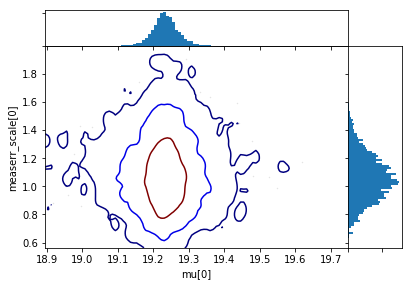

In [40]:
sample.plot_2dkde('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


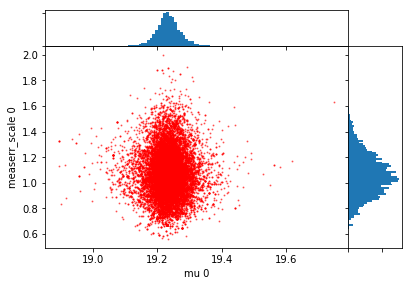

In [41]:
sample.plot_2dpdf('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


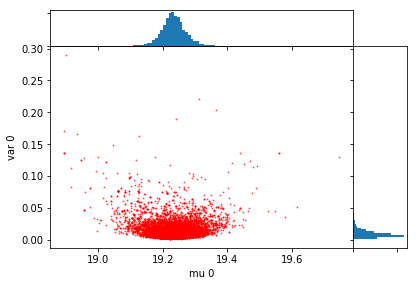

In [42]:
sample.plot_2dpdf('mu', 'var', doShow=True)

Plotting 2d PDF w KDE


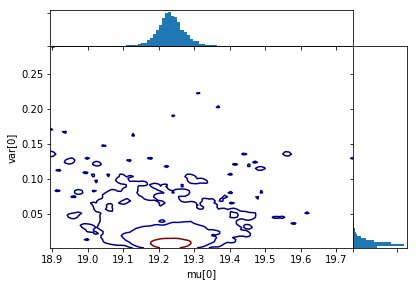

In [43]:
sample.plot_2dkde('mu', 'var', doShow=True)